In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cub'
import numpy as np
import cupy as cp
from cupyx import empty_pinned
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice with given pitch."""
    indices = np.arange(res)
    return (indices - res/2 + 0.5) * pitch

def compute_edges(res, pitch):
    """Return an array of shape (res+1) containing the edges of each sampling cell."""
    indices = np.arange(res+1)
    return (indices - res/2) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return np.floor(x / pitch + res/2).astype(np.int32)

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_a * (1.0 - z_b/z_f) - x_b * (1.0 - z_a/z_f)) * (z_r / (z_a - z_b))

def ra_to_p(x_r, x_a, z_r, z_a, z_f):
    """Return the coordinates on the pupil corresponding to the given coordinates on plane A and on the retina."""
    return (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)

def take_2d(values, idx_x, idx_y):
    """Return values at the cartesian product of given indices. Out of bounds are filled with 0."""
    clipped_idx_x = np.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = np.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values, 1, mode='constant')[clipped_idx_x,][..., clipped_idx_y]

def compute_imaging_tensor(x_r, edges_a, edges_b, z_r, z_a, z_b, z_f, pupil_diameter):
    """Return the flatland imaging tensor with shape (res_r, res_a, res_b)."""
    # Project edges to the pupil plane
    edges_a_at_p = ra_to_p(x_r[..., np.newaxis, np.newaxis], edges_a, z_r, z_a, z_f)
    edges_b_at_p = ra_to_p(x_r[..., np.newaxis, np.newaxis], edges_b, z_r, z_b, z_f)
    # Bounds imposed by the pupil aperture
    lower_bound = -pupil_diameter/2
    upper_bound =  pupil_diameter/2
    # Restrict plane A edges to the pupil aperture
    edges_pa = cp.clip(edges_a_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture and plane A edges together
    lower_bound = cp.minimum(edges_pa[..., :-1, :], edges_pa[..., 1:, :])
    upper_bound = cp.maximum(edges_pa[..., :-1, :], edges_pa[..., 1:, :])
    # Restrict plane B intervals to the pupil aperture and plane A intervals
    edges_pab = cp.clip(edges_b_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture, plane A intervals and plane B intervals together
    lower_bound = cp.minimum(edges_pab[..., :-1], edges_pab[..., 1:])
    upper_bound = cp.maximum(edges_pab[..., :-1], edges_pab[..., 1:])
    # Return the lengths of the intervals normalized by the pupil diameter
    return cp.subtract(upper_bound, lower_bound) / pupil_diameter

def apply_imaging_tensor(img_tsr, signal_ab):
    """Return the image formed by the given imaging tensor over the given light field."""
    return cp.tensordot(img_tsr, signal_ab, axes=((-1, -2), (-1, -2)))

def convolution_matrix(x_in, x_out, kernel):
    """Return a convolution matrix with given kernel."""
    return kernel(x_out[..., np.newaxis] - x_in)

def sinusoidal_signal(x, frequency, phase=0.0):
    """Sample a cosine with given frequency and phase at given sampling coordinates."""
    return cp.cos((x * frequency + phase) * 2 * np.pi)/2 + 0.5

def band_signal(x, thickness):
    """Return a signal composed of a single centered band with given thickness."""
    return (cp.abs(x) < thickness) * 1.0

def decimate_lf(signal_ab, factor):
    """Return the light field decimated by the given factor."""
    return signal_ab[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]

def create_filter(omega_a, omega_b, z_r, z_a, z_b, z_near, z_far, xi_r, xi_p=0.0):
    """Return the filter defined from near and far focus distance and maximum frequency at the retina."""
    mask_near = (z_near * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) < 0
    mask_far = (z_far * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) > 0
    mask_depth = cp.logical_not(cp.logical_xor(mask_near, mask_far))
    mask_p_near = cp.abs((1 - z_a/z_near) * omega_a + (1 - z_b/z_near) * omega_b) < xi_p
    mask_p_far = cp.abs((1 - z_a/z_far) * omega_a + (1 - z_b/z_far) * omega_b) < xi_p
    mask_p = cp.logical_or(mask_p_near, mask_p_far)
    mask_r = cp.abs(z_a * omega_a + z_b * omega_b) < abs(z_r) * xi_r
    return cp.logical_and(mask_r, cp.logical_or(mask_depth, mask_p)) * 1.0

def tile_lf(signal_ab):
    """Return a 2-dim tiling of 2-dim images from given 4-dim light field."""
    return signal_ab.reshape(np.prod(signal_ab.shape[0:2]), -1)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))

In [3]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 256
res_a = 256
res_b = 256

signal_shape = (res_a, res_b, res_a, res_b)
spectrum_shape = (res_a, res_b, res_a, res_b//2+1)

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

xi_r = 0.5 / pitch_r
xi_a = 0.5 / pitch_a
xi_b = 0.5 / pitch_b

In [4]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [5]:
x_r = compute_coordinates(res_r, pitch_r)
omega_r =  np.fft.fftfreq(res_r, pitch_r)

x_a = compute_coordinates(res_a, pitch_a)[    ::    , np.newaxis]
omega_a =  np.fft.fftfreq(res_a, pitch_a)[    ::    , np.newaxis]

x_b = compute_coordinates(res_b, pitch_b)[np.newaxis,     ::    ]
omega_b =  np.fft.fftfreq(res_b, pitch_b)[np.newaxis,     ::    ]

edges_a = compute_edges(res_a, pitch_a)[    ::    , np.newaxis]
edges_b = compute_edges(res_b, pitch_b)[np.newaxis,     ::    ]

edges_a_GPU = cp.asarray(edges_a)
edges_b_GPU = cp.asarray(edges_b)

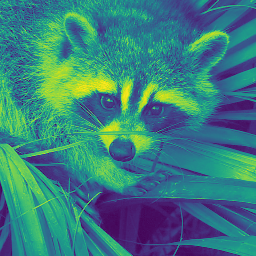

(256, 256) uint8 | total size: 6.103515625e-05 GiB


In [6]:
scene_image = misc.face(True).T[-769:-1:3, ::-3]
display_image(scene_image)
print(scene_image.shape, scene_image.dtype, '| total size:', scene_image.nbytes/2**30, 'GiB')

In [7]:
%%time
print('Sampling the light field signal...')

z_f = 1000.0

x_r_over_ab = ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f)
idx_r_over_ab = compute_indices(x_r_over_ab, res_r, pitch_r)
signal_ab = take_2d(scene_image, idx_r_over_ab, idx_r_over_ab)

print(signal_ab.shape, signal_ab.dtype, '| total size:', signal_ab.nbytes/2**30, 'GiB')

Sampling the light field signal...
(256, 256, 256, 256) uint8 | total size: 4.0 GiB
Wall time: 10 s


In [8]:
%%time
print('Computing the light field spectrum on CPU (single-pass)...')

spectrum_ab = scipy_fft.rfftn(signal_ab.astype(np.float32))

print(spectrum_ab.shape, spectrum_ab.dtype, '| total size:', spectrum_ab.nbytes/2**30, 'GiB')

Computing the light field spectrum on CPU (single-pass)...
(256, 256, 256, 129) complex64 | total size: 16.125 GiB
Wall time: 4min 26s


In [9]:
%%time
print('Computing the light field spectrum on CPU (multi-pass stage 1)...')

n_blocks = 8
block_size = res_a//n_blocks

print(n_blocks, 'blocks of size', spectrum_ab[0:block_size, ...].nbytes/2**30, 'GiB')

for i in range(n_blocks):
    spectrum_ab[block_size*i:block_size*(i+1), ...] = scipy_fft.rfft2(signal_ab[block_size*i:block_size*(i+1), ...].astype(np.float32))

Computing the light field spectrum on CPU (multi-pass stage 1)...
8 blocks of size 2.015625 GiB
Wall time: 1min 36s


In [10]:
%%time
print('Computing the light field spectrum on CPU (multi-pass stage 2)...')

n_blocks = 8
block_size = res_a//n_blocks

print(n_blocks, 'blocks of size', spectrum_ab[0:block_size, ...].nbytes/2**30, 'GiB')

for i in range(n_blocks):
    spectrum_ab[..., block_size*i:block_size*(i+1), :] = scipy_fft.fft2(spectrum_ab[..., block_size*i:block_size*(i+1), :], axes=(0, 1))

Computing the light field spectrum on CPU (multi-pass stage 2)...
8 blocks of size 2.015625 GiB
Wall time: 1min 4s


In [11]:
%%time
print('Computing the light field spectrum on GPU (multi-pass stage 1)...')

n_blocks = 8
block_size = res_a//n_blocks

print(n_blocks, 'blocks of size', spectrum_ab[0:block_size, ...].nbytes/2**30, 'GiB')

for i in range(n_blocks):
    spectrum_ab[block_size*i:block_size*(i+1), ...] = cupyx_fft.rfft2(cp.asarray(signal_ab[block_size*i:block_size*(i+1), ...]).astype(cp.float32)).get()

cp.fft.config.get_plan_cache().clear()

Computing the light field spectrum on GPU (multi-pass stage 1)...
8 blocks of size 2.015625 GiB
Wall time: 1min 9s


In [12]:
%%time
print('Computing the light field spectrum on GPU (multi-pass stage 2)...')

n_blocks = 8
block_size = res_a//n_blocks

print(n_blocks, 'blocks of size', spectrum_ab[0:block_size, ...].nbytes/2**30, 'GiB')

for i in range(n_blocks):
    spectrum_ab[..., block_size*i:block_size*(i+1), :] = cupyx_fft.fft2(cp.asarray(spectrum_ab[..., block_size*i:block_size*(i+1), :]), axes=(0, 1)).get()

cp.fft.config.get_plan_cache().clear()

Computing the light field spectrum on GPU (multi-pass stage 2)...
8 blocks of size 2.015625 GiB
Wall time: 23.4 s
